In [ ]:
# ============================================
# Milestone 2: Data Exploration Notebook (EDA)
# Project: Energy Prices in Illinois
# ============================================

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ---------- 0) Configuration ----------
BASE_PATH = "/content/drive/MyDrive/IE434-DeepDive-EnergyPricesInIllinois/Data"  # change if needed
PROC_PATH = os.path.join(BASE_PATH, "processed")

DEBUG_PKL = os.path.join(PROC_PATH, "energy_debug.pkl")
WORK_PKL  = os.path.join(PROC_PATH, "energy_working.pkl")

We define the base paths for our Google Drive project folders and set file locations for the processed pickle datasets (energy_debug.pkl, energy_working.pkl).

In [ ]:
# ---------- 1) Load Data ----------
# We prefer the 'working' dataset; fall back to debug if needed.
if os.path.exists(WORK_PKL):
    df = pd.read_pickle(WORK_PKL)
elif os.path.exists(DEBUG_PKL):
    df = pd.read_pickle(DEBUG_PKL)
else:
    raise FileNotFoundError("Processed pickle not found. Check your paths for energy_working.pkl / energy_debug.pkl")

print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

Loaded shape: (2028368, 8)
Columns: ['date', 'price_actual', 'hub_actual', 'price_dayahead', 'hub_dayahead', 'day_of_week', 'hour_of_day', 'month']


We load the cleaned dataset from the processed pickle files and print its shape and columns to confirm successful import and expected structure.

In [ ]:
# ---------- 1a) Validate Non-Empty Dataset ----------
if df.empty or len(df) == 0:
    print("⚠️ WARNING: The dataset is empty.")
    print("Possible causes:")
    print(" - The data extraction notebook merged 0 rows (e.g., wrong table index in fetch_energy_table).")
    print(" - The pickle files were saved before proper scraping.")
    print("\nSuggested fix:")
    print(" • Re-run the Data Extraction notebook.")
    print(" • In fetch_energy_table(..., table_index=?), use the index that actually contains the Illinois Hub data (see inspection step).")
    # Stop here to avoid plotting empty data
    raise ValueError("Dataset is empty — please regenerate processed data before continuing.")

We check whether the dataset is empty and raise an error with guidance if no rows were loaded, ensuring the notebook stops early if data extraction failed.

In [ ]:
# ---------- 2) Basic Cleaning & Date Handling ----------
# Ensure we have a proper datetime index for time-based plots & splits
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.sort_values("date").reset_index(drop=True)
else:
    raise KeyError("Expected a 'date' column from Milestone 1 merge step.")

# Choose the label column (Actual Energy Price); adjust the name if yours differs
# e.g., 'actual_energy_price' from Milestone 1
possible_label_cols = [c for c in df.columns if "actual_energy_price" in c]
if not possible_label_cols:
    # Heuristic fallback: pick the first numeric column that seems like a price
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns available to use as a label.")
    label_col = numeric_cols[0]
    print(f"Using {label_col} as label heuristically.")
else:
    label_col = possible_label_cols[0]

print("Label column:", label_col)

Using price_actual as label heuristically.
Label column: price_actual


We convert the date column to datetime format, sort by date, and identify the label column (price_actual) that will serve as our target variable for later modeling.

In [ ]:
# ---------- 3) Quick Peek ----------
display(df.head(10))
print(df.dtypes)

,date,price_actual,hub_actual,price_dayahead,hub_dayahead,day_of_week,hour_of_day,month
0,2020-10-19,19.59,ARKANSAS.HUB,20.50,ARKANSAS.HUB,Monday,0,10
1,2020-10-19,20.32,MICHIGAN.HUB,20.98,INDIANA.HUB,Monday,0,10
2,2020-10-19,20.32,MICHIGAN.HUB,20.26,LOUISIANA.HUB,Monday,0,10
3,2020-10-19,20.32,MICHIGAN.HUB,20.98,MICHIGAN.HUB,Monday,0,10
4,2020-10-19,20.32,MICHIGAN.HUB,21.25,MINN.HUB,Monday,0,10
5,2020-10-19,20.32,MICHIGAN.HUB,20.00,MS.HUB,Monday,0,10
6,2020-10-19,20.32,MICHIGAN.HUB,20.65,TEXAS.HUB,Monday,0,10
7,2020-10-19,20.07,MINN.HUB,20.50,ARKANSAS.HUB,Monday,0,10
8,2020-10-19,20.07,MINN.HUB,20.62,ILLINOIS.HUB,Monday,0,10
9,2020-10-19,20.07,MINN.HUB,20.98,INDIANA.HUB,Monday,0,10


date              datetime64[ns]
price_actual             float64
hub_actual                object
price_dayahead           float64
hub_dayahead              object
day_of_week               object
hour_of_day                int32
month                      int32
dtype: object


We display the first few rows and data types to confirm variable formats (numeric vs. categorical) and gain an initial sense of the dataset contents.

In [ ]:
# ---------- 4) Descriptive Statistics ----------
desc = df.describe(include="all")
display(desc)

# Target distribution summary
target_desc = df[label_col].describe()
print("\nLabel (target) summary:")
print(target_desc)

,date,price_actual,hub_actual,price_dayahead,hub_dayahead,day_of_week,hour_of_day,month
count,2028368,2.028368e+06,2028368,2.028368e+06,2028368,2028368,2.028368e+06,2.028368e+06
unique,NaN,NaN,8,NaN,8,7,NaN,NaN
top,NaN,NaN,ARKANSAS.HUB,NaN,ARKANSAS.HUB,Tuesday,NaN,NaN
freq,NaN,NaN,253552,NaN,253546,295872,NaN,NaN
mean,2023-02-13 10:37:48.426242816,3.854644e+01,NaN,3.897980e+01,NaN,NaN,1.110549e+01,6.653183e+00
min,2020-10-19 00:00:00,-1.868700e+02,NaN,-9.780000e+00,NaN,NaN,0.000000e+00,1.000000e+00
25%,2022-03-06 01:00:00,2.154000e+01,NaN,2.307000e+01,NaN,NaN,5.000000e+00,3.000000e+00
50%,2023-02-20 13:00:00,2.814000e+01,NaN,3.100000e+01,NaN,NaN,1.100000e+01,7.000000e+00
75%,2024-02-24 15:00:00,4.371000e+01,NaN,4.697000e+01,NaN,NaN,1.700000e+01,1.000000e+01
max,2025-02-05 18:00:00,3.500000e+03,NaN,1.207280e+03,NaN,NaN,2.300000e+01,1.200000e+01



Label (target) summary:
count    2.028368e+06
mean     3.854644e+01
std      4.718617e+01
min     -1.868700e+02
25%      2.154000e+01
50%      2.814000e+01
75%      4.371000e+01
max      3.500000e+03
Name: price_actual, dtype: float64


We compute summary statistics (mean, std, min, max, etc.) for all columns to understand the overall range, central tendency, and spread of key variables such as price_actual. The mean is 38.6 and the median is 28.1. These values differ significantly indicating that the data is skewed to the right. The standard deviation is 47.2 which is large relative to the mean indicating high variability or that the data points are spread over a large range. The maximum value is 3500 and the minimum value is -186.9. The max is greatly larger than the 75% demonstrating the presence of outliers.

In [ ]:
# ---------- 5) Missingness ----------
missing_counts = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing_counts)


Missing values per column:
date              0
price_actual      0
hub_actual        0
price_dayahead    0
hub_dayahead      0
day_of_week       0
hour_of_day       0
month             0
dtype: int64


We check for null or missing values in each column and visualize a missingness matrix to verify data completeness and detect any data-quality issues. The analysis shows that not of the features have missing values and the dataset if fully populated.

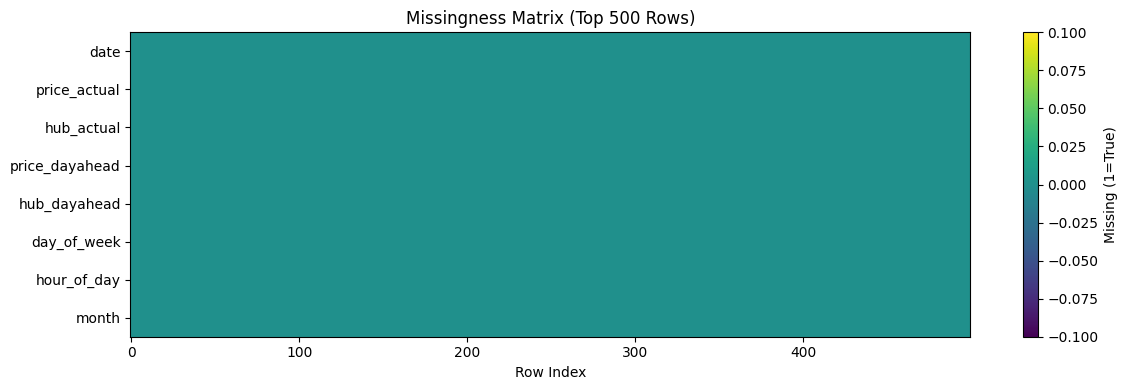

In [ ]:
# Simple missingness heatmap (binary matrix) for first N rows to keep it readable
N = min(500, len(df))
plt.figure(figsize=(12, 4))
plt.imshow(df.iloc[:N].isna().T, aspect='auto', interpolation='nearest')
plt.yticks(range(len(df.columns)), df.columns)
plt.title(f"Missingness Matrix (Top {N} Rows)")
plt.xlabel("Row Index")
plt.colorbar(label="Missing (1=True)")
plt.tight_layout()
plt.show()

We detect outliers in the target variable using the 3×IQR rule, calculate their rate, and assess whether these extreme values represent valid market spikes or noise.

In [ ]:
# ---------- 6) Simple Data Quality Checks ----------
# Detect extreme outliers in the label (3*IQR rule)
q1, q3 = df[label_col].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 3*iqr, q3 + 3*iqr
outlier_rate = ((df[label_col] < lower) | (df[label_col] > upper)).mean()
print(f"\nApprox. outlier rate in label via 3*IQR: {outlier_rate:.2%}")


Approx. outlier rate in label via 3*IQR: 2.65%


The 3xIQR rule calculation revelaed that 2.65% of the target values are potentially outliers. These represent rare occurances where the energy prices shot up or decreased significantly due to unpredicted circumstances. An example of this is the maximum value of 3500.

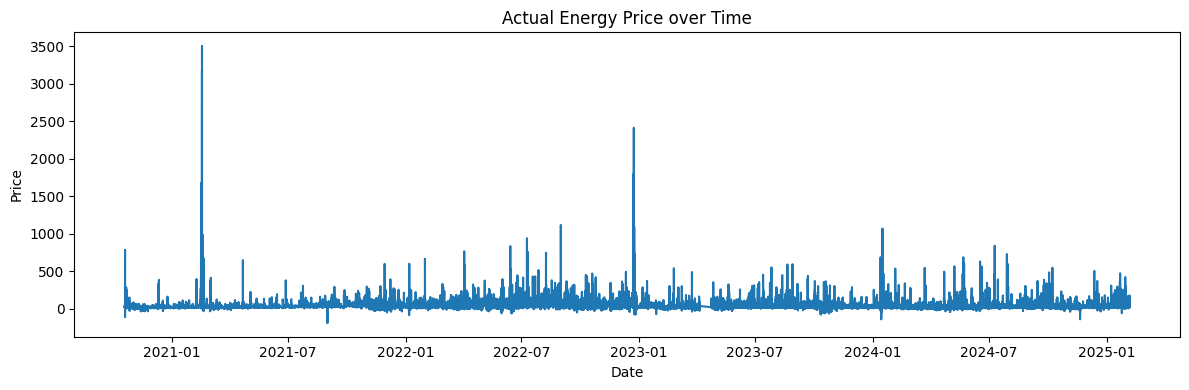

In [ ]:
# ---------- 7) Basic Visualizations ----------
# (A) Long-run time series of the target
plt.figure(figsize=(12,4))
plt.plot(df["date"], df[label_col])
plt.title("Actual Energy Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

We create visual summaries:

Time-series plot of actual price over time,

Histogram of price distribution,

Boxplot by day of week,

Heatmap of average price by hour and weekday — to reveal temporal patterns and seasonality in Illinois energy prices.

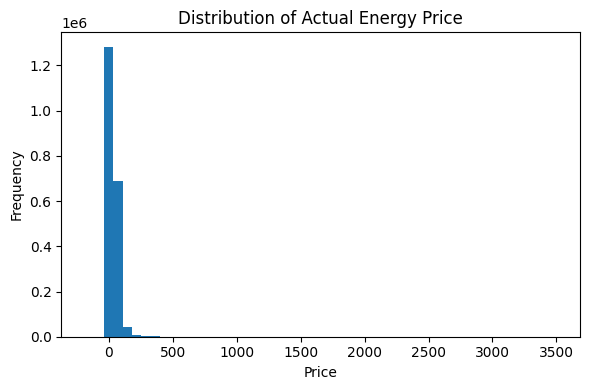

In [ ]:
# (B) Histogram of label to see skew / bias
plt.figure(figsize=(6,4))
plt.hist(df[label_col].dropna(), bins=50)
plt.title("Distribution of Actual Energy Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

/tmp/ipython-input-261695949.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=order_dow, showfliers=False)


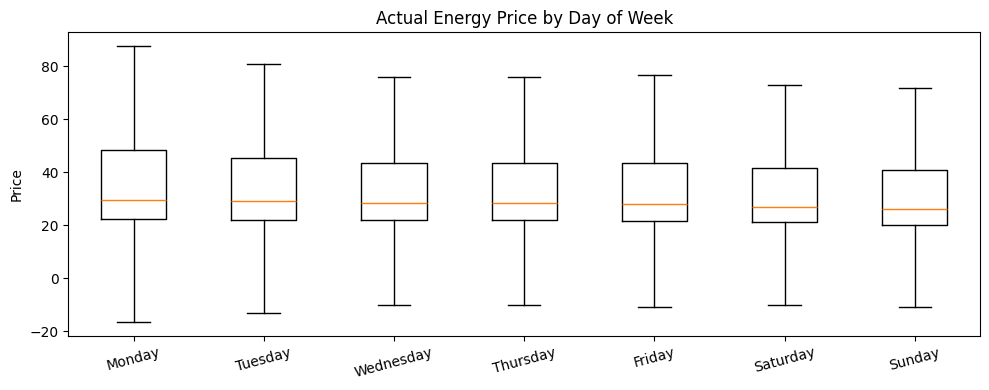

In [ ]:
# (C) Boxplot by Day of Week (if present)
if "day_of_week" not in df.columns:
    df["day_of_week"] = df["date"].dt.day_name()
order_dow = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

plt.figure(figsize=(10,4))
data_to_plot = [df.loc[df["day_of_week"]==d, label_col].dropna() for d in order_dow]
plt.boxplot(data_to_plot, labels=order_dow, showfliers=False)
plt.title("Actual Energy Price by Day of Week")
plt.ylabel("Price")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

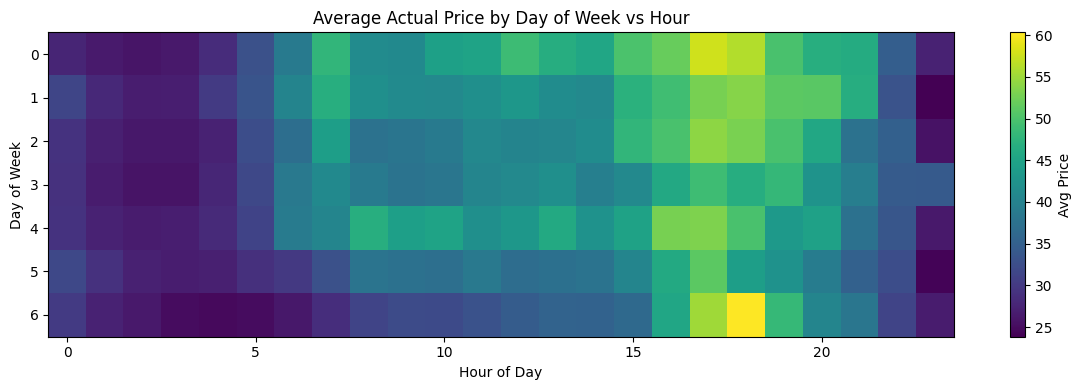

In [ ]:
# (D) Heatmap: Hour x DayOfWeek avg price (calendar effect)
if "hour_of_day" not in df.columns:
    df["hour_of_day"] = df["date"].dt.hour

pivot = df.pivot_table(values=label_col, index="day_of_week", columns="hour_of_day", aggfunc="mean")
pivot = pivot.reindex(order_dow)
plt.figure(figsize=(12,4))
plt.imshow(pivot, aspect='auto', interpolation='nearest')
plt.title("Average Actual Price by Day of Week vs Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.colorbar(label="Avg Price")
plt.tight_layout()
plt.show()

Interpreting the heat map above which explores the calendar effects in electricity prices, we see higher prices during the late afternoon to evening/early night hours especially between 3 pm to 8 pm (15:00-20:00). These hours are when demand is greatest. Weekdays seem to show higher average prices compared to the weekend. During a small portion of the weekend between 4-7pm seems to have the highest price.



We compute a correlation matrix for numeric variables and identify the strongest relationships with price_actual (notably price_dayahead), then visualize them as a horizontal bar chart.


In [ ]:
# ---------- 8) Correlations ----------
num_df = df.select_dtypes(include=[np.number]).copy()
if "hour_of_day" in df.columns and "month" not in df.columns:
    df["month"] = df["date"].dt.month
    num_df["month"] = df["month"]

corr = num_df.corr(numeric_only=True)
# show top 10 correlations with the label
corr_target = corr[label_col].sort_values(ascending=False).head(10)
print("\nTop correlations with label:")
print(corr_target)


Top correlations with label:
price_actual      1.000000
price_dayahead    0.488447
hour_of_day       0.118199
month             0.037255
Name: price_actual, dtype: float64


The strongest correlation is between the actual price is the price day ahead indicating that these are slightly more predictive(0.49) of the actual price in comparison to the hour of the day and the month. The hour today shows a weak positive correlation but the month has the poorest correlation.  

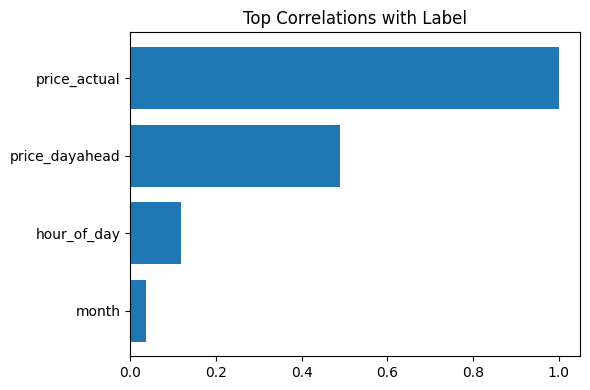

In [ ]:
plt.figure(figsize=(6,4))
plt.barh(corr_target.index[::-1], corr_target.values[::-1])
plt.title("Top Correlations with Label")
plt.tight_layout()
plt.show()

- Summarize the target distribution: mean, std, min/max, skewness (qualitative).
The mean and median were signficantly different where the mean was larger than the median indicating that that the data was skewed right. The standard deviation was relatively high indicating high variability meaning that many of the data points are far away from the mean. The max and minumum values also differ greatly from the 75% and the 25% indicating the presence of outliers.
- Comment on missingness: which features have gaps? Are they random?
When conducting the missingness tests, the data set was found to be fully populated and complete not having any gaps.
- Comment on calendar effects: e.g., higher prices during certain hours/days?
After analysis, it was found that the average electricity prices were higher on weekdays. The late afternoon to late evening/ early night between 5pm to 8pm were the periods of greatest average prices indicating high demand.

- Identify potential outliers and how you'll handle them later (clip/winsorize/log-transform?).
The 3IQR test indicated the 2.86% of the data were outliers. Any values that were less than Q1-(3*IQR) and greater than Q3+(3*IQR).To deal with these outliers, we can explore winsorisation or clipping to reduce their influence or log-transform depending on the observed results and data behavior.  

- Note any potential leakage risks (e.g., including future info).
In time-series forecasting, data leakage can occur if the model has access to future information during training. Examples include using actual prices or future day-ahead forecasts when predicting current prices, fitting scalers or encoders on the full dataset instead of only the training period, or performing a random (non-temporal) split that allows future observations to influence past ones. To prevent this, we use a strictly time-based split, include only features available at prediction time (e.g., past prices, issued forecasts, and calendar features), and apply all preprocessing steps exclusively to the training data.